# Bank marketing prediction with XGBOOST

Machine Learning with Vertex AI custom model
Requires XGBoost 

Uses dataset:
https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

HINT: Dataset is available among Google's public datasets: `'gs://cloud-ml-tables-data/bank-marketing.csv`  
HINT: The target `Deposit` column indicates whether the client purchased a term deposit (2 = yes, 1 = no)  
see also: https://www.cloudskillsboost.google/focuses/43565?parent=catalog

In [58]:
# basics
import pandas as pd
import plotly.express as px

# model, metrics
import sklearn.metrics as metrics 
import sklearn.model_selection as msel 
import sklearn.preprocessing as proc
import xgboost as xgb

# storage
import google.cloud as gcloud

In [3]:
dataset_path_kaggle = '/kaggle/input/bank-marketing-dataset/bank.csv'
dataset_path_google = 'gs://cloud-ml-tables-data/bank-marketing.csv' # HINT: public dataset
df=pd.read_csv(dataset_path_google)
df.sample(5)

,Age,Job,MaritalStatus,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,PDays,Previous,POutcome,Deposit
22528,40,technician,married,tertiary,no,1207,no,no,cellular,22,aug,105,3,-1,0,unknown,1
30201,35,management,divorced,tertiary,no,500,yes,no,cellular,5,feb,177,1,252,1,failure,1
9210,44,technician,married,secondary,no,358,no,no,unknown,5,jun,179,1,-1,0,unknown,1
21616,36,technician,single,secondary,no,818,yes,yes,cellular,19,aug,96,4,-1,0,unknown,1
36545,41,blue-collar,married,primary,no,194,yes,no,cellular,12,may,201,1,-1,0,unknown,1


In [7]:
print(df.info())
print('nans:')
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Age            45211 non-null  int64 
 1   Job            45211 non-null  object
 2   MaritalStatus  45211 non-null  object
 3   Education      45211 non-null  object
 4   Default        45211 non-null  object
 5   Balance        45211 non-null  int64 
 6   Housing        45211 non-null  object
 7   Loan           45211 non-null  object
 8   Contact        45211 non-null  object
 9   Day            45211 non-null  int64 
 10  Month          45211 non-null  object
 11  Duration       45211 non-null  int64 
 12  Campaign       45211 non-null  int64 
 13  PDays          45211 non-null  int64 
 14  Previous       45211 non-null  int64 
 15  POutcome       45211 non-null  object
 16  Deposit        45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB
None
nans:


Age              0
Job              0
MaritalStatus    0
Education        0
Default          0
Balance          0
Housing          0
Loan             0
Contact          0
Day              0
Month            0
Duration         0
Campaign         0
PDays            0
Previous         0
POutcome         0
Deposit          0
dtype: int64

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



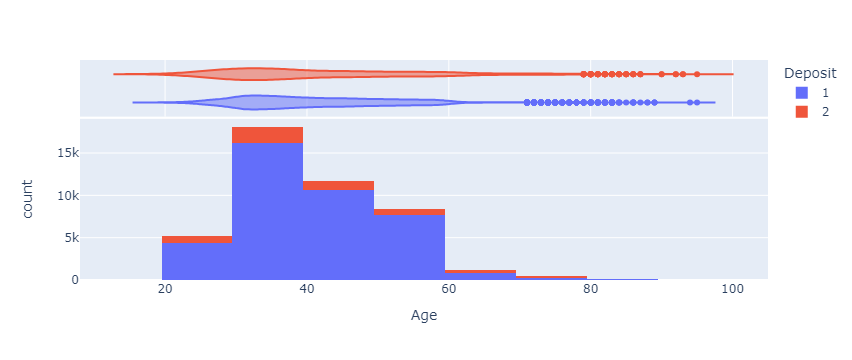

In [45]:
fig_ages = px.histogram(df, x='Age', nbins=10, color='Deposit', marginal='violin')
fig_ages.show()

In [59]:
import sklearn.metrics as metrics
import sklearn.model_selection as msel
import sklearn.preprocessing as proc
import xgboost as xgb

## Data preprocessing

* No need to convert / remove: NaNs - none of them
* No need to scale: XGBoost is unaffected
* Convert categorical / numerical columns neither scaling
  * until model's `enable_categorical` param is implemented
* Target column has [1 2] - must be converted to [0 1], as otherwise  `ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got [1 2]`

In [30]:
categorical_columns = [col for col in df.columns if not pd.api.types.is_numeric_dtype(df[col])]
categorical_columns

['Job',
 'MaritalStatus',
 'Education',
 'Default',
 'Housing',
 'Loan',
 'Contact',
 'Month',
 'POutcome']

In [39]:
label_encoder = proc.LabelEncoder()
for cat in categorical_columns:
    df[cat] = label_encoder.fit_transform(df[cat])

In [40]:
target = 'Deposit'
X = df.loc[:, df.columns != target]
y = df[target]
y = y.map({2:1, 1:0}) # 2: 'has deposited (1)', 1: 'no deposit (0)'

In [41]:
test_train_split = 0.2
X_train, X_test, y_train, y_test = msel.train_test_split(
    X,
    y,
    test_size = 0.2,
    random_state= random_state
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36168, 16), (9043, 16), (36168,), (9043,))

In [42]:
random_state = 7
model = xgb.XGBClassifier(
    objective = 'binary:logistic', 
    # HINT: categorical is unsupported: ValueError: Experimental support for categorical data is not implemented for current tree method yet.
    # enable_categorical = True, # HINT: otherwise complains about categorical columns (e.g. need preprocess)
    random_state = random_state)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=7, ...)

In [37]:
print(f'Training score: {model.score(X_train, y_train)}| Test score: {model.score(X_test,y_test)}')

Training score: 0.9515870382658704| Test score: 0.9117549485790114


In [47]:
y_pred = model.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
conf_matrix

array([[7746,  281],
       [ 517,  499]])

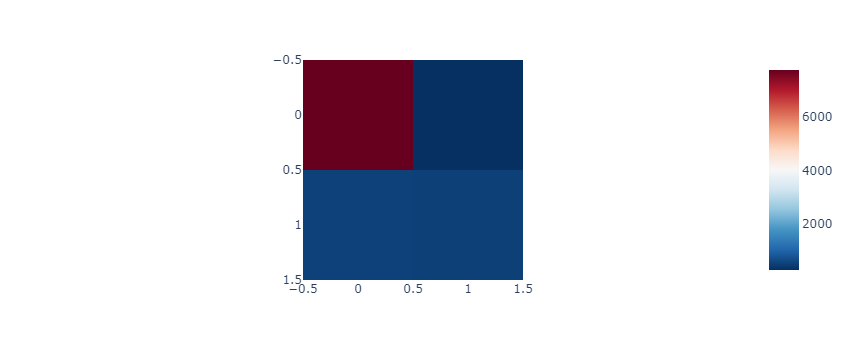

In [49]:
fig_conf_matrix = px.imshow(conf_matrix, color_continuous_scale='RdBu_r')
fig_conf_matrix.show()

HINT: unbalanced dataset - poor

In [50]:
metrics.f1_score(y_test, y_pred)

0.5556792873051225

## Save model

Unfortunately can't just: `model.save_model('gs://my-fine-bucket/model')`

See also:  
* XGBoost docu - model saving: https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html
* Google cloud documentation: 
 * saving model to Google bucket
https://cloud.google.com/ai-platform/training/docs/training-xgboost?ssp=1&darkschemeovr=1&setlang=en-PH&safesearch=moderate#train-and-upload-model
 * bucket storage https://cloud.google.com/python/docs/reference/storage/latest/google.cloud.storage.blob.Blob#google_cloud_storage_blob_Blob_upload_from_filename

In [57]:
import google.cloud as gcloud

In [73]:
# TODO: any project/env variables?
# Export the model to a file
model_file = 'model.json'
model.save_model(model_file)

In [74]:
# TODO: use project/env variables
bucket_name = 'tomasz-bucket'
gs_model_path = 'bank-marketing/model/xgboost'

bucket = gcloud.storage.Client().bucket(bucket_name)
blob = bucket.blob(f'{gs_model_path}/{model_file}')

blob.upload_from_filename(model_file)

## Load model

In [75]:
loaded_model = xgb.XGBClassifier()
loaded_model_file = 'model_loaded.json'
blob.download_to_filename(loaded_model_file)
loaded_model.load_model(loaded_model_file)

In [76]:
y_pred = loaded_model.predict(X_test)
metrics.f1_score(y_test, y_pred)

0.5556792873051225